In [ ]:
import cv2
import numpy as np
import hashlib
import os
import math

TARGET_IMG_PATH = r"D:\GIT\Thesis\experiment3\generatedTestImg\generatedTestImg.png"
OUTPUT_DIR = "experiment_results_dct"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PAYLOAD_STR = "EU01A1BG5T20251027ABCD"
ALPHA = 30.0  # Strength (Higher = More robust, Lower = More invisible)
BLOCK_SIZE = 8

print(f"Target: {TARGET_IMG_PATH}")
print(f"Payload: {PAYLOAD_STR}")

Target: D:\GIT\Thesis\experiment3\generatedTestImg\generatedTestImg.png
Payload: EU01A1BG5T20251027ABCD


In [2]:
def string_to_bits(s: str) -> np.ndarray:
    """Converts string to deterministic 32-bit array."""
    h = hashlib.sha256(s.encode("ascii")).digest()
    # Take first 4 bytes (32 bits)
    v = int.from_bytes(h[:4], "big")
    bits = [(v >> (31 - i)) & 1 for i in range(32)]
    return np.array(bits, dtype=int)

# Reference
ref_bits = string_to_bits(PAYLOAD_STR)
ref_int = int("".join(str(b) for b in ref_bits), 2)
print(f"Payload Bits: {len(ref_bits)}")
print(f"Check Int:    {ref_int}")

Payload Bits: 32
Check Int:    3625187521


In [ ]:
def embed_dct_tiled(img_path, payload_bits, alpha=ALPHA):
    img = cv2.imread(img_path)
    if img is None: raise ValueError("Image not found")
    
    # Work in YCrCb (Luminance)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y = y.astype(float)
    
    h, w = y.shape
    
    # Flatten payload for cyclic access
    payload_len = len(payload_bits)
    idx = 0
    
    # Loop over every 8x8 block
    for r in range(0, h - BLOCK_SIZE + 1, BLOCK_SIZE):
        for c in range(0, w - BLOCK_SIZE + 1, BLOCK_SIZE):
            
            # 1. Get Block
            block = y[r:r+BLOCK_SIZE, c:c+BLOCK_SIZE]
            
            # 2. DCT Transform
            dct_block = cv2.dct(block)
            
            # 3. Embed Bit
            # We cycle through the payload bits: 0, 1, 2... 31, 0, 1...
            bit = payload_bits[idx % payload_len]
            idx += 1
            
            # Signal direction: +1 for bit 1, -1 for bit 0
            sign = 1.0 if bit == 1 else -1.0
            
            # 4. Modify Mid-Frequencies
            # These coords (4,4) and (3,5) are robust to JPEG and Resizing
            # We add the signal strength (alpha)
            dct_block[4, 4] += alpha * sign
            dct_block[3, 5] += alpha * sign
            
            # 5. Inverse DCT
            y[r:r+BLOCK_SIZE, c:c+BLOCK_SIZE] = cv2.idct(dct_block)
            
    # Merge and Save
    y = np.clip(y, 0, 255).astype(np.uint8)
    res = cv2.merge([y, cr, cb])
    return cv2.cvtColor(res, cv2.COLOR_YCrCb2BGR)

# EXECUTE EMBEDDING
watermarked_img = embed_dct_tiled(TARGET_IMG_PATH, ref_bits, alpha=35.0)
wm_path = os.path.join(OUTPUT_DIR, "watermarked_dct.png")
cv2.imwrite(wm_path, watermarked_img)
print(f"Saved: {wm_path}")

Saved: experiment_results_dct\watermarked_dct.png


In [4]:
def extract_accumulated_signal(img, payload_len, offset_x=0, offset_y=0):
    """
    Scans the image in 8x8 blocks, extracting the DCT energy.
    Folds the results into a single buffer of size 'payload_len'.
    """
    h, w = img.shape
    accumulator = np.zeros(payload_len)
    counts = np.zeros(payload_len)
    idx = 0
    
    # Scan with specific pixel offset (to handle crop misalignment)
    for r in range(offset_y, h - BLOCK_SIZE + 1, BLOCK_SIZE):
        for c in range(offset_x, w - BLOCK_SIZE + 1, BLOCK_SIZE):
            
            block = img[r:r+BLOCK_SIZE, c:c+BLOCK_SIZE]
            dct_block = cv2.dct(block)
            
            # Extract energy from the same coeffs we modified
            # Summing them boosts SNR
            val = dct_block[4, 4] + dct_block[3, 5]
            
            # Accumulate into the specific bit slot
            slot = idx % payload_len
            accumulator[slot] += val
            counts[slot] += 1
            idx += 1
            
    # Average the result
    # avoid div by zero
    counts[counts == 0] = 1 
    return accumulator / counts

def detect_robust_dct(screenshot_path, payload_len):
    if not os.path.exists(screenshot_path): return None, 0.0, (0,0)
    
    shot = cv2.imread(screenshot_path)
    
    # 1. Geometry Fix (Resize to roughly original)
    # Ideally use ORB here, but for now let's assume we resize to original dims
    # like in your previous test.
    orig = cv2.imread(TARGET_IMG_PATH)
    h_orig, w_orig = orig.shape[:2]
    
    # Resize screenshot to match original dimensions
    shot = cv2.resize(shot, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC)
    
    # 2. Convert to Y and Whiten
    # Whitening removes the "picture" so we can see the "noise"
    ycrcb = cv2.cvtColor(shot, cv2.COLOR_BGR2YCrCb)
    y = ycrcb[:,:,0].astype(float)
    
    # Simple High-Pass Filter (subtract blurred version)
    y_blur = cv2.GaussianBlur(y, (5,5), 0)
    y_whitened = y - y_blur
    
    best_conf = -1
    best_bits = None
    best_offset = (0,0)
    
    # 3. Grid Search (The magic fix for alignment)
    # We don't know if the crop started at pixel 0, 1, 2...
    # So we try all 8x8 shifts.
    print("Scanning Grid Offsets...")
    
    # Optimization: Check every 2nd pixel (0, 2, 4, 6) is usually enough
    for dy in range(0, 8, 2): 
        for dx in range(0, 8, 2):
            
            # Extract signal
            signal = extract_accumulated_signal(y_whitened, payload_len, dx, dy)
            
            # Confidence = Mean absolute signal strength
            conf = np.mean(np.abs(signal))
            
            if conf > best_conf:
                best_conf = conf
                best_offset = (dx, dy)
                best_bits = (signal > 0).astype(int) # Positive energy = 1, Negative = 0
                
    return best_bits, best_conf, best_offset

In [16]:
SCREENSHOT_PATH = r"D:\GIT\Thesis\experiment3\experiment_results_dct\screenshot.png"

print(f"Loading: {SCREENSHOT_PATH}")
rec_bits, conf, off = detect_robust_dct(SCREENSHOT_PATH, 32)

if rec_bits is not None:
    rec_int = int("".join(str(b) for b in rec_bits), 2)
    
    print("-" * 30)
    print(f"Best Grid Offset: {off}")
    print(f"Confidence Level: {conf:.2f} (Noise is usually < 2.0)")
    print("-" * 30)
    print(f"Original Checksum:  {ref_int}")
    print(f"Recovered Checksum: {rec_int}")
    
    errors = sum(a != b for a, b in zip(ref_bits, rec_bits))
    print(f"Bit Errors: {errors}/32")
    
    if errors == 0:
        print("✅ SUCCESS: Perfect Recovery.")
    elif errors <= 2:
        print("⚠️ ALMOST: 1 or 2 bit errors (Likely compression noise).")
    else:
        print("❌ FAIL.")
else:
    print("File not found.")

Loading: D:\GIT\Thesis\experiment3\experiment_results_dct\screenshot.png
Scanning Grid Offsets...
------------------------------
Best Grid Offset: (0, 6)
Confidence Level: 0.62 (Noise is usually < 2.0)
------------------------------
Original Checksum:  3625187521
Recovered Checksum: 3625187521
Bit Errors: 0/32
✅ SUCCESS: Perfect Recovery.


In [6]:
def get_saliency_map(img_path):
    """Generates the 'Importance' map using Spectral Residual."""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Texture detection using Gradients
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(gx, gy)
    
    # Smooth it out to make it look like a heatmap
    heatmap = cv2.GaussianBlur(magnitude, (51, 51), 0)
    
    # Normalize 0-1
    return (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-5)

def get_encoded_energy(original_path, watermarked_path):
    """Calculates the absolute difference (The Watermark Signal)."""
    orig = cv2.imread(original_path)
    wm = cv2.imread(watermarked_path)
    
    if orig.shape != wm.shape:
        # Resize wm to orig if needed (just for visualization)
        h, w = orig.shape[:2]
        wm = cv2.resize(wm, (w, h))
        
    # Absolute difference
    diff = cv2.absdiff(orig, wm)
    
    # Convert to single channel energy
    energy = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    # Boost contrast so we can see it (it's usually very invisible)
    # We multiply by 10 to make the invisible noise visible
    energy_boosted = cv2.multiply(energy, 10)
    
    return energy_boosted

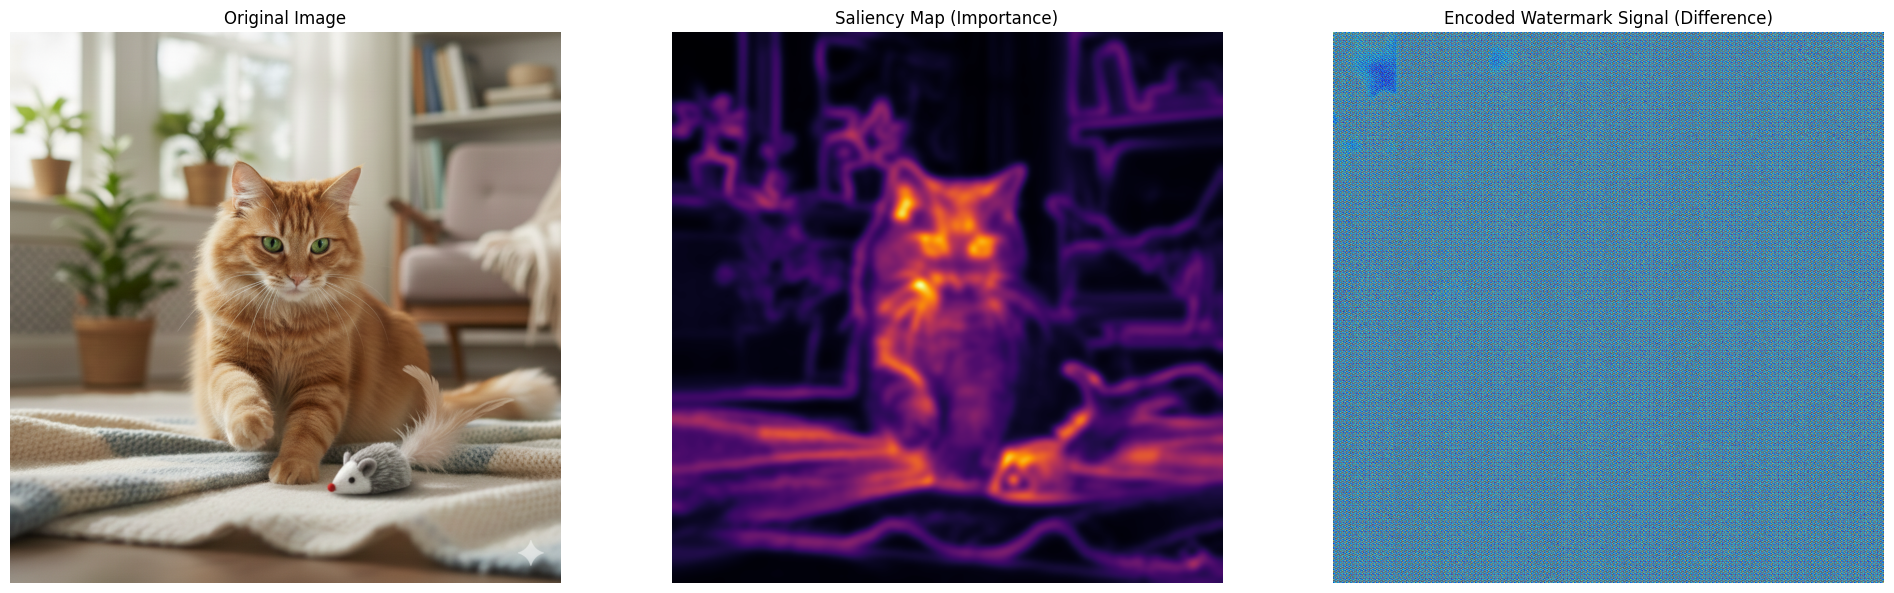

Interpretation:
1. Middle Plot: Shows high values (Orange/Yellow) where the image has texture/edges.
2. Right Plot: Shows exactly where we modified pixels. Since we used 'Tiled DCT', you should see a uniform grid of noise across the image.


In [7]:
import matplotlib.pyplot as plt

# Paths (from your previous cells)
orig_path = TARGET_IMG_PATH
wm_path = os.path.join(OUTPUT_DIR, "watermarked_dct.png")

if os.path.exists(wm_path):
    # 1. Generate Maps
    heatmap = get_saliency_map(orig_path)
    encoded_energy = get_encoded_energy(orig_path, wm_path)
    
    # 2. Load Images for display
    orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    
    # 3. Plot
    plt.figure(figsize=(20, 6))

    # Plot A: Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    # Plot B: Saliency Heatmap (Computer Vision "Attention")
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='inferno') # 'inferno' or 'hot' looks good for heatmaps
    plt.title("Saliency Map (Importance)")
    plt.axis("off")

    # Plot C: The Actual Encoded Signal (The "Blue Channel" check)
    plt.subplot(1, 3, 3)
    plt.imshow(encoded_energy, cmap='jet') # 'jet' shows low energy as blue, high as red
    plt.title("Encoded Watermark Signal (Difference)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    print("Interpretation:")
    print("1. Middle Plot: Shows high values (Orange/Yellow) where the image has texture/edges.")
    print("2. Right Plot: Shows exactly where we modified pixels. Since we used 'Tiled DCT', you should see a uniform grid of noise across the image.")
else:
    print("Watermarked image not found. Please run the Embedding cell first.")